In [735]:
import pandas as pd
import numpy as np

import random
import os

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import DBSCAN

data_dir = os.path.join(os.getcwd(), "data")

df_fire = pd.read_csv(f"{data_dir}/fire/ca_fire_dataset.csv")

In [3]:
df_fire.head()

,DATE,GMT,LAT,LON,NAME,ADMIN1,ADMIN2,AREA,TEMP
0,2010-09-24,601,42.431,-121.170,Tulelake,California,Siskiyou County,0.0,308.4
1,2010-09-24,601,42.431,-121.170,Tulelake,California,Siskiyou County,0.0,308.4
2,2010-09-24,605,42.431,-121.170,Tulelake,California,Siskiyou County,0.0,308.4
3,2010-05-14,2102,42.246,-121.335,Tulelake,California,Siskiyou County,0.0,326.9
4,2010-05-14,2103,42.246,-121.335,Tulelake,California,Siskiyou County,0.0,326.9


In [733]:
# Sample some lat-lon coordinates, calculate their euclidean distance
# NOAA has a lat-lon to miles calculator: 
# https://www.nhc.noaa.gov/gccalc.shtml
# this can be used to get a sense of the distances between fire detections

ll1 = np.array([42.246, -121.170])
ll2 = np.array([42.431, -121.335])
np.linalg.norm(ll1-ll2) # ll1 and ll2 is about 11 miles away according to NOAA

0.24789110512480192

In [734]:
# time series runs from 2010-2018
(df_fire['DATE'].min(), df_fire['DATE'].max())

('2010-01-06', '2018-12-27')

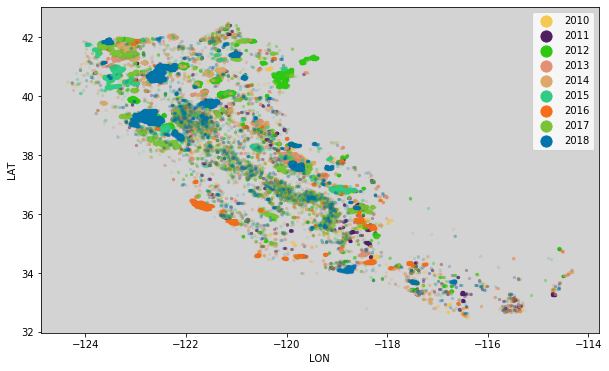

In [19]:
chars = '0123456789ABCDEF'

df_fire_sample = df_fire
labels = list(range(2010, 2019))
colors = {i: '#'+''.join(random.sample(chars,6)) for i in labels}
date_idx = 0

c = df_fire_sample['DATE'].apply(lambda x: colors[int(x.split("-")[date_idx])])
ax = None
for label in labels:
    label_mask = df_fire_sample['DATE'].apply(lambda x: int(x.split("-")[date_idx])) == label
    df_fire_sample_f = df_fire_sample[label_mask]
    if not ax:
        ax = df_fire_sample_f.plot(x="LON", y="LAT", kind='scatter',
                                 c=colors[label], s=5.0, figsize=(10, 6), alpha=0.1, label=label)
    else:
        df_fire_sample_f.plot(x="LON", y="LAT", kind='scatter',
                            c=colors[label], s=5.0, figsize=(10, 6), alpha=0.1, ax=ax, label=label)
ax.set_facecolor('lightgray')
leg = ax.legend(markerscale=5.0)

for lh in leg.legendHandles: 
    lh.set_alpha(1)

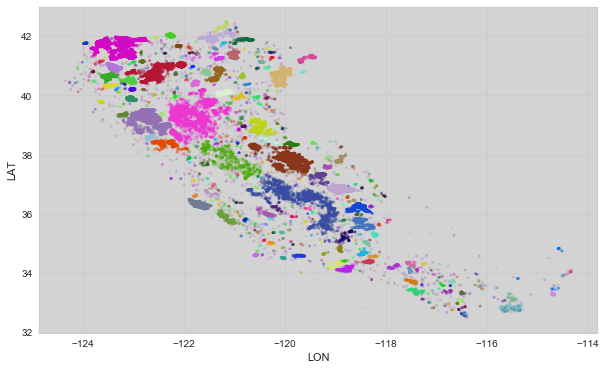

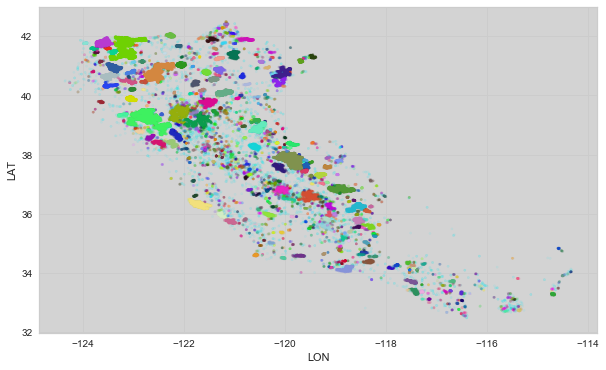

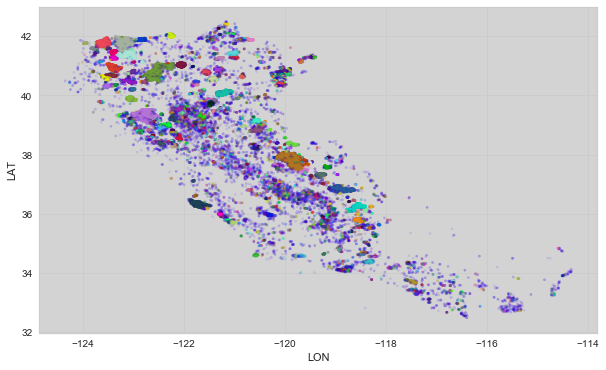

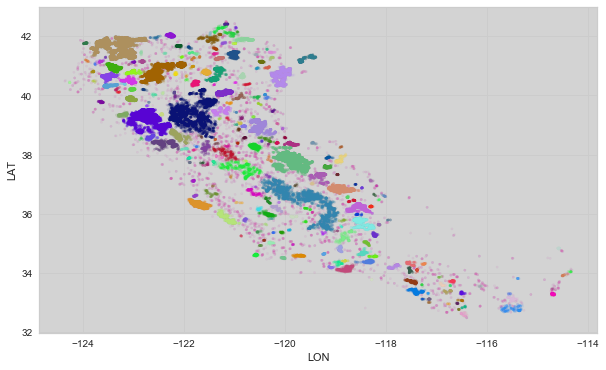

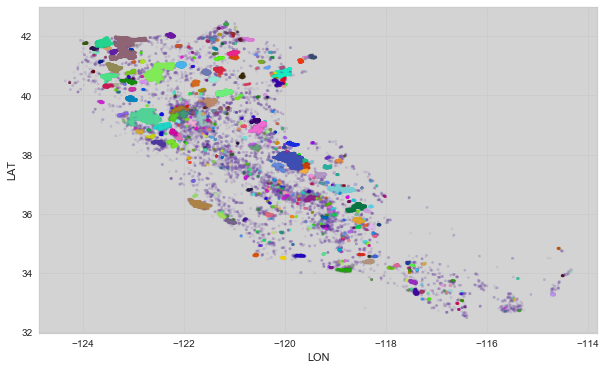

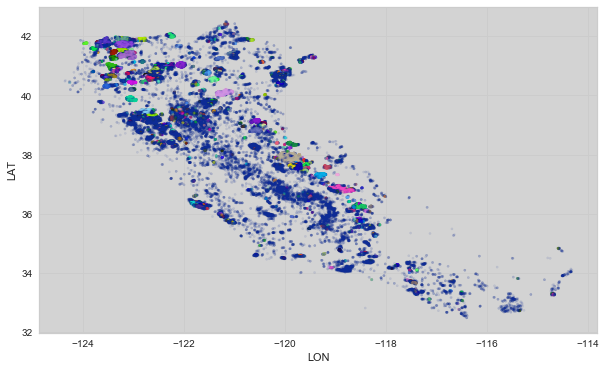

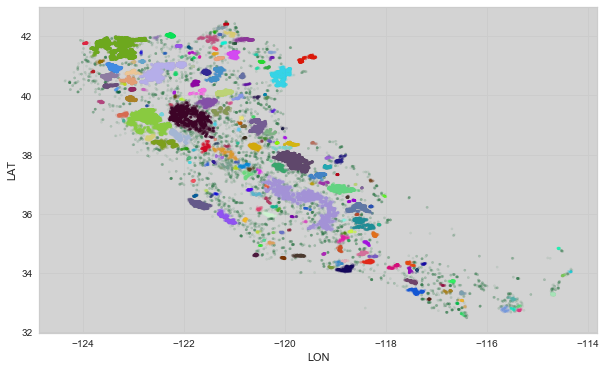

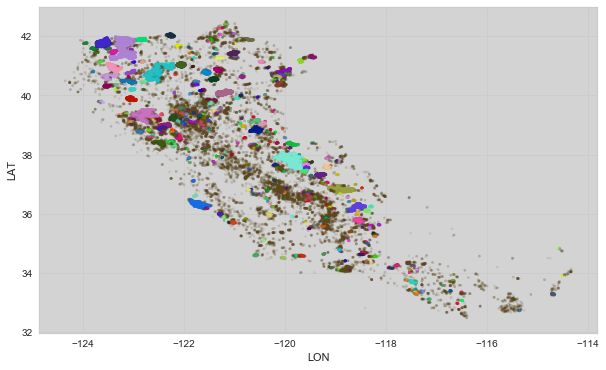

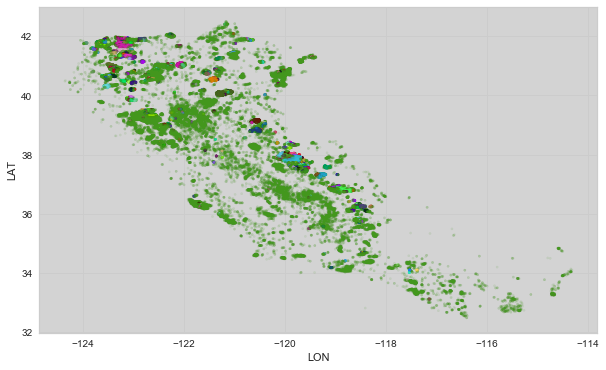

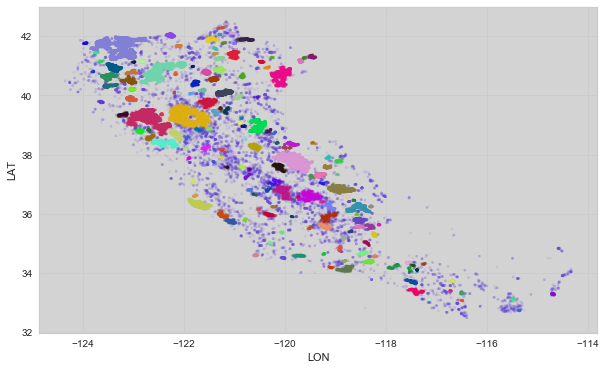

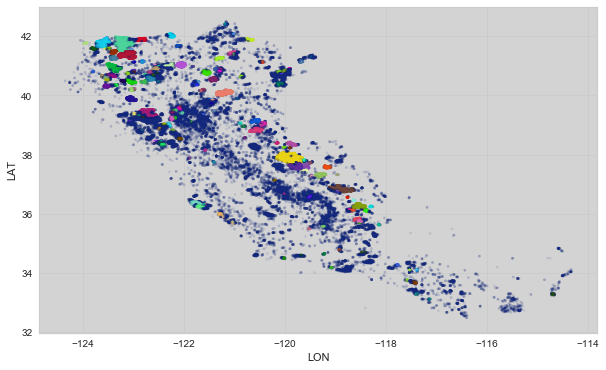

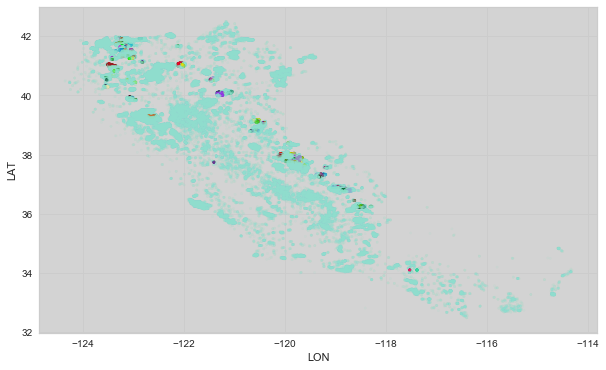

In [746]:
from sklearn.cluster import KMeans, DBSCAN

X = df_fire[["LAT", "LON"]].to_numpy()

# Experiment with a few different hyperparameters

epsilons = [0.05, 0.02, 0.01]
min_samples_grid = [5, 15, 25, 50]

for min_samples in min_samples_grid:
    for eps in epsilons:
        eps = eps
        min_samples = min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(X)

        df_fire[f'dbscan_labels_{eps}_{min_samples}'] = dbscan.labels_

        hex_colors = ['#'+''.join(random.sample(chars,6)) for i in range(len(set(dbscan.labels_)))]
        c = [hex_colors[l] for l in dbscan.labels_]
        ax = df_fire.plot(x="LON", y="LAT", kind='scatter', c=c, alpha=0.1, s=5.0, figsize=(10, 6))
        ax.set_facecolor('lightgray')
        plt.savefig(f'dbscan_labels_{eps}_{min_samples}.png')

In [736]:
dbscan_label_columns = [column for column in df_fire.columns if 'dbscan_labels_' in column]

gb_arr = []
for column in dbscan_label_columns:
    gb = df_fire.groupby(column).agg({"LAT": "mean", "LON": "mean", "DATE": "count"})
    gb['label'] = column
    gb_arr.append(gb)
centroids_per_cluster_set = pd.concat(gb_arr)

ValueError: No objects to concatenate

In [750]:
# Seems like a low setting of the min_samples hyperparameter results
# in more clusters, which seems like expected behavior. 
centroids_per_cluster_set.groupby("label").size().reset_index().sort_values(by=0, ascending=False)

,label,0
2,dbscan_labels_0.001_5,1935
6,dbscan_labels_0.002_5,1132
0,dbscan_labels_0.001_15,607
4,dbscan_labels_0.002_15,500
10,dbscan_labels_0.005_5,450
1,dbscan_labels_0.001_25,362
5,dbscan_labels_0.002_25,339
13,dbscan_labels_0.25_25,307
8,dbscan_labels_0.005_15,248
9,dbscan_labels_0.005_25,216


2010: 85 clusters
2011: 93 clusters
2012: 102 clusters
2013: 93 clusters
2014: 110 clusters
2015: 49 clusters
2016: 60 clusters
2017: 68 clusters
2018: 74 clusters


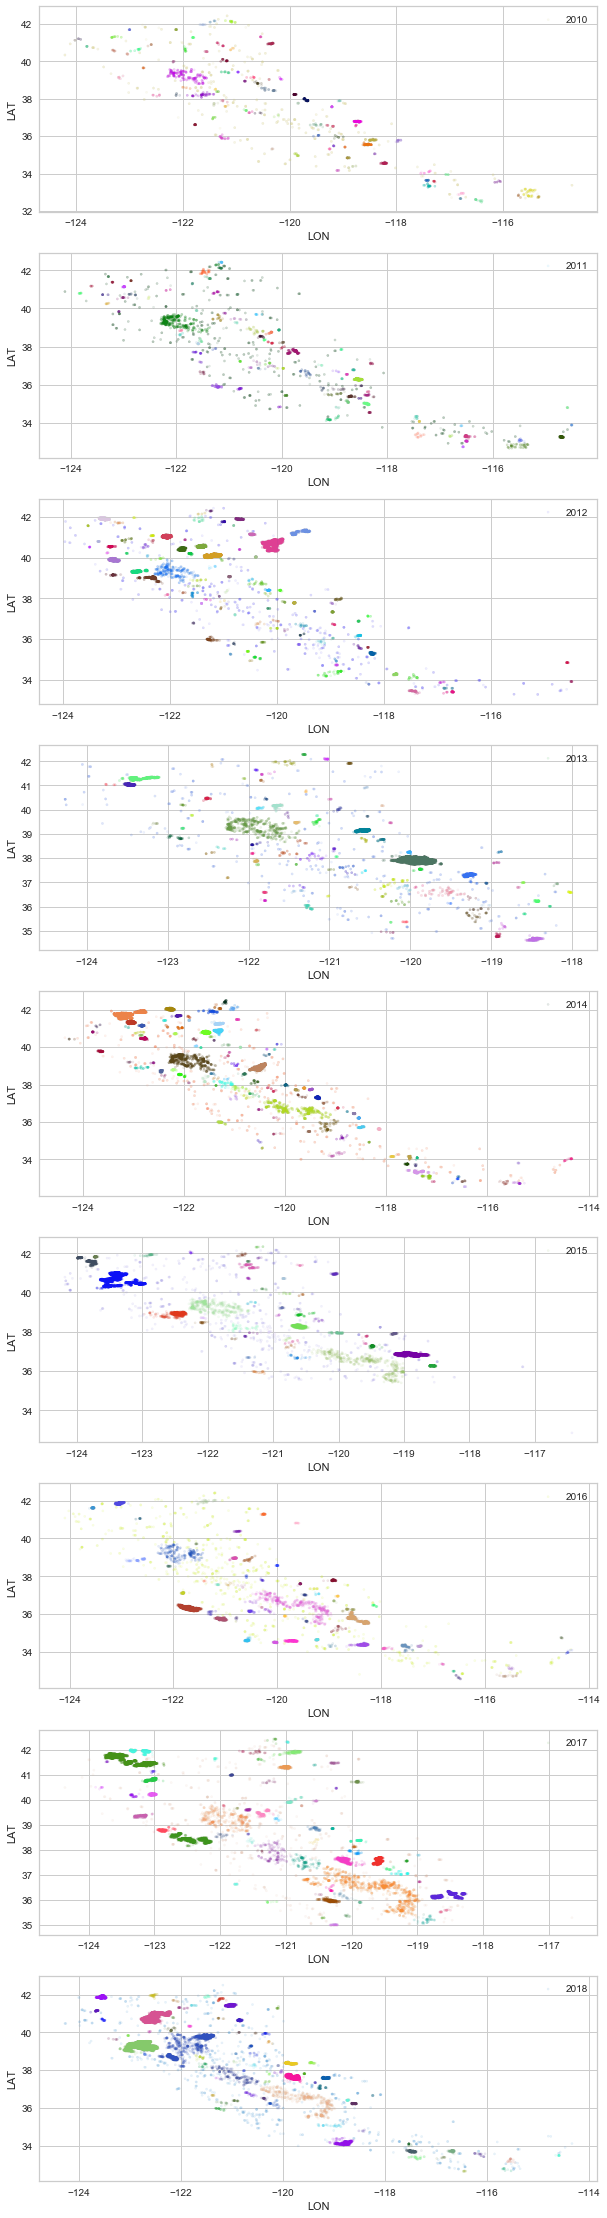

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


import random
chars = '0123456789ABCDEF'

df_fire_sample = df_fire
labels = list(range(2010, 2019))
colors = {i: '#'+''.join(random.sample(chars,6)) for i in labels}
date_idx = 0


fig, axes = plt.subplots(len(labels), figsize=(10,40))
for i, label in enumerate(labels):
    label_mask = df_fire_sample['DATE'].apply(lambda x: int(x.split("-")[date_idx])) == label
    df_fire_sample_f = df_fire_sample[label_mask]
    X = df_fire_sample_f[["LAT", "LON"]].to_numpy()

    dbscan = DBSCAN(eps=0.1, min_samples=10)
    dbscan.fit(X)

    hex_colors = ['#'+''.join(random.sample(chars,6)) for i in range(len(set(dbscan.labels_)))]    
    c = [hex_colors[l] for l in dbscan.labels_]
    print(f"{label}: {len(np.unique(dbscan.labels_))} clusters")
    df_fire_sample_f.plot(x="LON", y="LAT", kind='scatter',
                        c=c, s=5.0, alpha=0.1, ax=axes[i], label=label)